# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload
import seaborn as sns

import sys
sys.path.insert(1, '../t-recs/')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo

import src.globals as globals
from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens, collect_parameters, load_measurements
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, RecallMeasurement, UserMSEMeasurement
import src.globals as globals

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_82832/2532379127.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
n_attrs=20
max_iter=1000
n_clusters=20

binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

# Define topic clusters using NMF
item_topics = get_topic_clusters(binary_ratings_matrix, n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.
Loaded clusters.


In [3]:
# Create user clusters based off how often they interacted with the same item
print('Calculating clusters...')
co_occurence_matrix = binary_ratings_matrix @ binary_ratings_matrix.T
print(co_occurence_matrix.shape)

# Matrix factorize co_occurence_matrix to get embeddings
nmf_cooc = NMF(n_components=n_attrs, max_iter=max_iter)
W_topics = nmf_cooc.fit_transform(co_occurence_matrix)

# cluster W_topics
cluster_ids = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state).fit_predict(W_topics)

print('Calculated clusters.')

Calculating clusters...
(943, 943)
Calculated clusters.


# Simulation

In [4]:
score_fn = ''
probabilistic = False
globals.ALPHA = 0.2
alpha = globals.ALPHA

# User parameters
drift = 0.2
attention_exp=1.5
pair_all=False

In [5]:
num_users = len(user_representation)
num_items = len(item_representation)
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

if pair_all:
    # All possible user pairs
    user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]

else:
    # create user_pairs by pairing users only with others that are not in the same cluster
    user_pairs = []
    for u_idx in range(num_users):
        for v_idx in range(num_users):
            if cluster_ids[u_idx] != cluster_ids[v_idx]:
                user_pairs.append((u_idx, v_idx))
print(f'Number of user pairs: {len(user_pairs)}')
                
users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

Number of items: 20
Number of users: 943
Number of user pairs: 769020


In [6]:
mse = MSEMeasurement()
measurements_list = [
    InteractionMeasurement(), 
    MSEMeasurement(),  
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric(),
    RecallMeasurement(),
    UserMSEMeasurement(),
]

In [7]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_topics,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness        
    else:
        raise Exception('Given score function does not exist.')
    model_name = score_fn

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [8]:
model = BubbleBurster(**config)

model.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {model.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {model.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 20)
- A randomly generated matrix of items of dimension (20, 1682)


In [9]:
# Fair Model
train_timesteps=5
model.startup_and_train(timesteps=train_timesteps)

100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


In [10]:
run_timesteps=20
model.run(timesteps=run_timesteps)

100%|██████████| 20/20 [02:02<00:00,  6.12s/it]


Measurements saved.


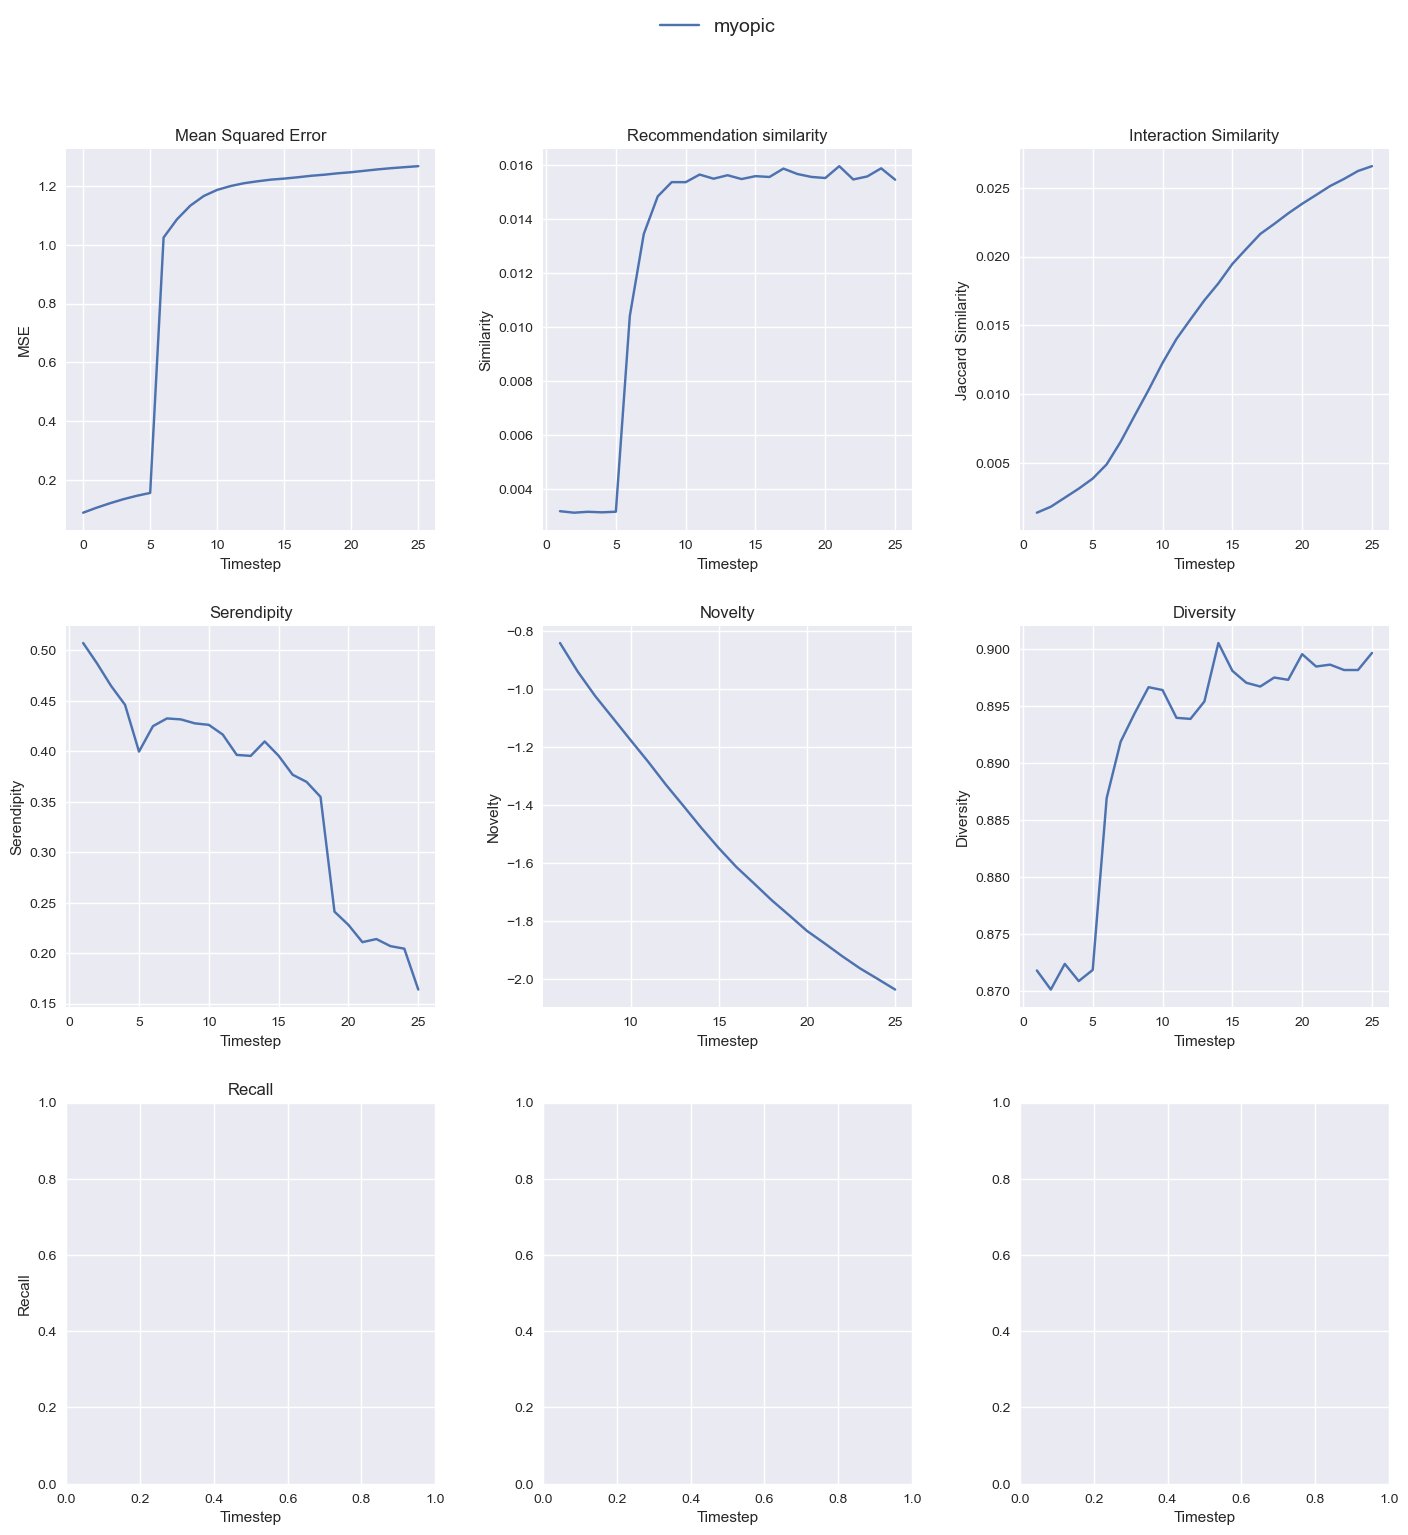

In [11]:
import src
reload(src.utils)
from src.utils import *
    
# Save measurements
measurements_dir = f'artefacts/experiment_measurements/'
file_name = f'{model_name}_measurements_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp_{pair_all}PairAll'
measurements_path = measurements_dir + file_name
if requires_alpha:
    measurements_path += f'_{alpha}Lambda'
measurements_path += '.csv'
measurements_df = load_or_create_measurements_df(model, model_name, train_timesteps, measurements_path)
measurements_df.to_csv(measurements_path)
print('Measurements saved.')

# Create df for parametrics
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])
    
plot_measurements([measurements_df], parameters_df)

In [12]:
measurements_df.head(3)

,interaction_histogram,mse,interaction_spread,interaction_similarity,rec_similarity,serendipity_metric,diversity_metric,novelty_metric,recall_at_k,user_mse,timesteps,state,model,lambda
0,NaN,0.090065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.03512269 0.08176823 0.16119423 0.2149699 0...,0,train,myopic,0.2
1,[4. 0. 0. ... 0. 0. 0.],0.106959,-939.5,0.001394,0.003169,0.507317,0.871816,NaN,0.979852,[0.06374638 0.1014931 0.14340149 0.27080583 0...,1,train,myopic,0.2
2,[1. 1. 1. ... 0. 0. 0.],0.122103,0.0,0.001827,0.003113,0.486957,0.870143,NaN,0.992577,[0.11547496 0.10116669 0.14667842 0.25307415 0...,2,train,myopic,0.2


In [13]:
# Getting `user_mse` values for each timestep
measurements = model.get_measurements()
user_mse = measurements['user_mse']
user_mse = np.array(user_mse).T
user_mse.shape

(943, 26)

In [14]:
# Getting user clusters

def USER_get_topic_clusters(interaction_matrix, n_clusters:int=100, n_attrs:int=100, max_iter:int=100):
    """
    Creates clusters of movies based on their genre.
    Inputs:
    binary_ratings_matrix: a binary matrix of users and movies
    n_attrs: number of attributes to use in NMF
    nmf_solver: solver to use in NMF
    Outputs:
    clusters: a list of cluster assignments
    """
    # Create topic clusters
    #create co-occurence matrix from binary_interaction_matrix print('Calculating clusters...')
    co_occurence_matrix = interaction_matrix.T @ interaction_matrix
    co_occurence_matrix = interaction_matrix.T @ interaction_matrix
    # Matrix factorize co_occurence_matrix to get embeddings
    nmf_cooc = NMF(n_components=n_attrs, max_iter=max_iter, verbose=1)
    W_topics = nmf_cooc.fit_transform(co_occurence_matrix)
    # cluster W_topics
    cluster_ids = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state, verbose=1).fit_predict(W_topics)
    # np.save(file_path, cluster_ids)
    print('Calculated clusters.') 
    return cluster_ids

n_clusters=50
max_iter=500
n_attrs=100
user_clusters = USER_get_topic_clusters(binary_ratings_matrix.T, n_clusters=n_clusters, max_iter=max_iter)#, nmf_solver=nmf_solver)
print(user_clusters.shape)
print(item_topics.shape)

violation: 1.0
violation: 6.784018506573518e-05
Converged at iteration 3
Initialization complete
Iteration 0, inertia 27.615833173464317.
Iteration 1, inertia 21.128904955469757.
Iteration 2, inertia 20.526659942572945.
Iteration 3, inertia 20.324379602460176.
Iteration 4, inertia 20.168126885024197.
Iteration 5, inertia 20.111611620958094.
Iteration 6, inertia 20.08163179661491.
Iteration 7, inertia 20.07008338406856.
Iteration 8, inertia 20.05644718406003.
Iteration 9, inertia 20.052394702137548.
Iteration 10, inertia 20.052119992198588.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 27.847174383237302.
Iteration 1, inertia 21.761598341368284.
Iteration 2, inertia 21.15337034633603.
Iteration 3, inertia 20.99779963145608.
Iteration 4, inertia 20.918925324433275.
Iteration 5, inertia 20.87184843833451.
Iteration 6, inertia 20.83381379249438.
Iteration 7, inertia 20.83339689808163.
Converged at iteration 7: strict convergence.
Initialization

In [16]:
df_user_mse = pd.DataFrame(user_mse)
df_user_mse['clusterID'] = user_clusters
df_user_mse.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,clusterID
0,0.035123,0.063746,0.115475,0.127452,0.142730,0.162493,0.805676,0.872726,0.915251,0.996148,...,1.149347,1.138810,1.125252,1.108358,1.141195,1.146791,1.127511,1.114021,1.126702,26
1,0.081768,0.101493,0.101167,0.101207,0.102961,0.116572,0.936633,1.011599,1.058284,1.093698,...,1.158062,1.150722,1.149202,1.137899,1.153936,1.162753,1.179181,1.176805,1.170269,18
2,0.161194,0.143401,0.146678,0.159490,0.164695,0.200517,0.998241,1.139335,1.267051,1.291202,...,1.528960,1.512567,1.521849,1.551609,1.544192,1.534862,1.542550,1.571826,1.550921,48
3,0.214970,0.270806,0.253074,0.238141,0.257395,0.249674,0.987792,1.042477,1.093040,1.129341,...,1.207037,1.194265,1.185529,1.193778,1.191480,1.189637,1.197268,1.198454,1.190074,16
4,0.018582,0.033315,0.042441,0.062535,0.061825,0.083669,1.464091,1.452602,1.418175,1.386154,...,1.320603,1.269250,1.249466,1.263589,1.247956,1.264024,1.278209,1.289518,1.277926,44


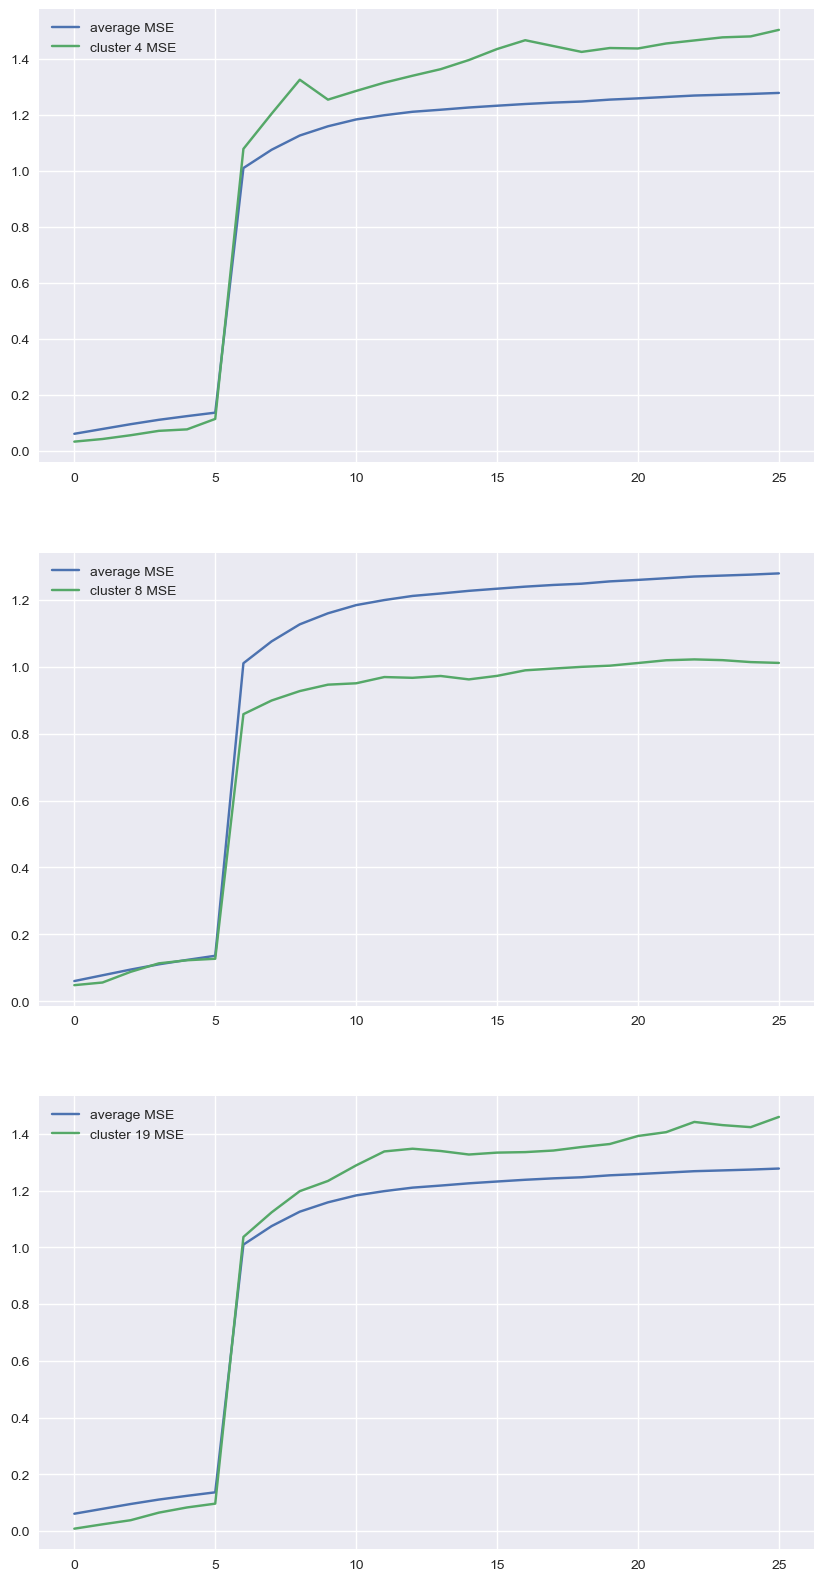

In [17]:
cluster_mse = df_user_mse.groupby(['clusterID']).mean()
all_min_mse_user_clusters = np.unique(cluster_mse.idxmin().values)
mean_mse = cluster_mse.mean()

fig, ax = plt.subplots(nrows=all_min_mse_user_clusters.size, ncols=1, figsize=(10, 20))
# print(all_min_mse_user_clusters)
# cluster_mse[all_min_mse_user_clusters[0]]

for i in range(all_min_mse_user_clusters.size):
    # print(f"cluster {all_min_mse_user_clusters[i]} MSE")
    ax[i].plot(mean_mse, label = "average MSE")
    ax[i].plot(cluster_mse.loc[all_min_mse_user_clusters[i]], label = f"cluster {all_min_mse_user_clusters[i]} MSE")
    ax[i].legend()
plt.legend()


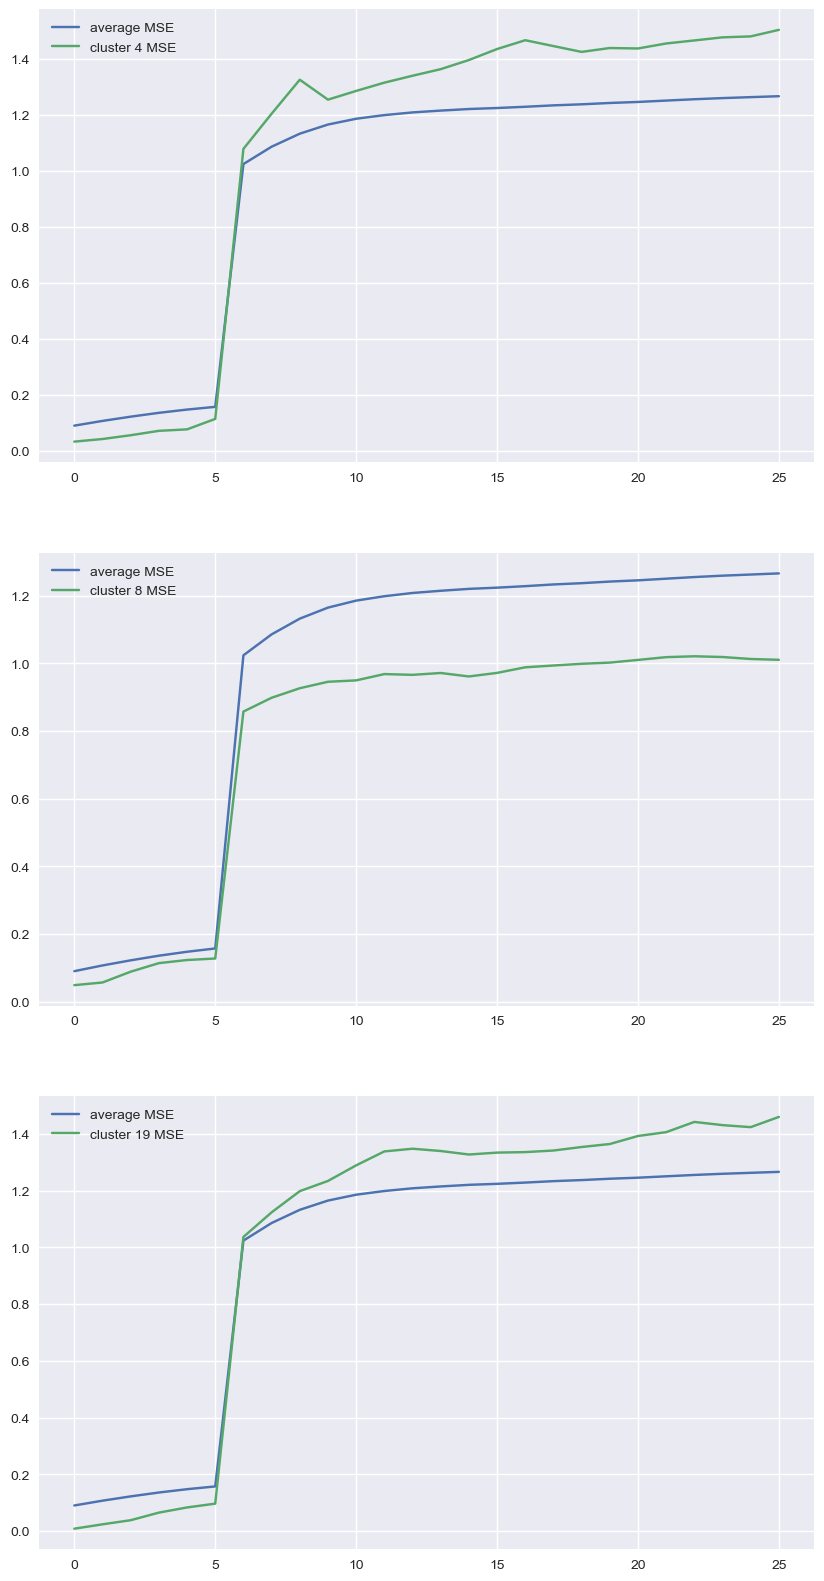

In [18]:
fig, ax = plt.subplots(nrows=all_min_mse_user_clusters.size, ncols=1, figsize=(10, 20))
# print(all_min_mse_user_clusters)
# cluster_mse[all_min_mse_user_clusters[0]]

for i in range(all_min_mse_user_clusters.size):
    # print(f"cluster {all_min_mse_user_clusters[i]} MSE")
    ax[i].plot(measurements['mse'], label = "average MSE")
    ax[i].plot(cluster_mse.loc[all_min_mse_user_clusters[i]], label = f"cluster {all_min_mse_user_clusters[i]} MSE")
    ax[i].legend()
plt.legend()


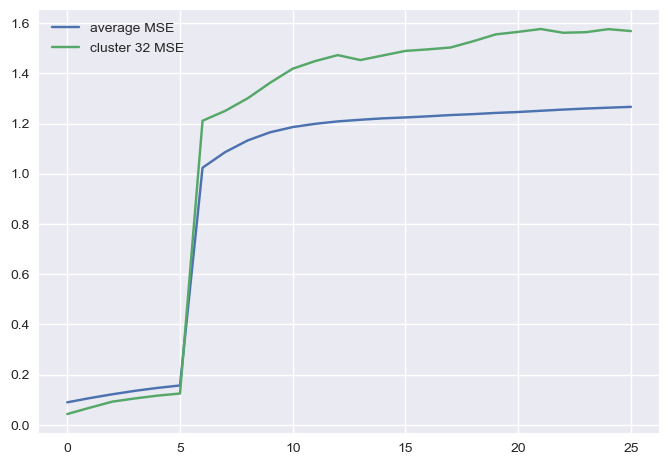

In [39]:
i = 32
plt.plot(measurements['mse'], label = "average MSE")
plt.plot(cluster_mse.loc[i], label = f"cluster {i} MSE")
plt.legend()
plt.legend()

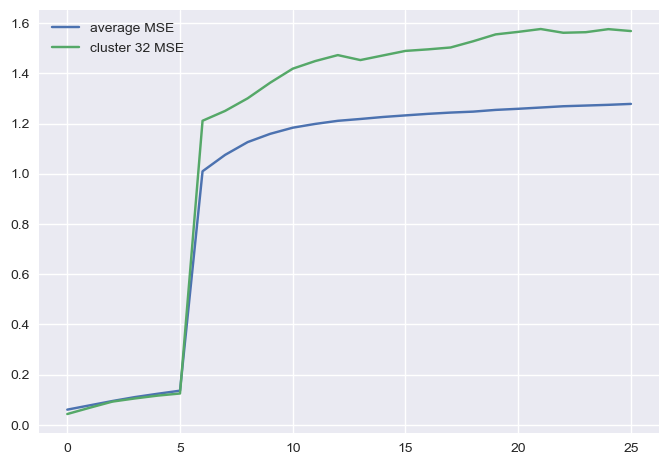

In [17]:
from src.utils import analyze_user_mse

analyze_user_mse(df_user_mse)